In [1]:
from symred.symplectic_form import PauliwordOp, StabilizerOp
from symred.S3_projection import (S3_projection, 
                                  gf2_gaus_elim, 
                                  gf2_basis_for_gf2_rref, 
                                  QubitTapering, 
                                  CS_VQE, 
                                  CheatS_VQE)
from symred.build_model import build_molecule_for_projection
from symred.utils import exact_gs_energy, quasi_model
import json
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import openfermion as of
import openfermionpyscf as ofpyscf
from openfermion.circuits import ( uccsd_singlet_get_packed_amplitudes,
                                   uccsd_singlet_generator, uccsd_generator,
                                   uccsd_convert_amplitude_format)
from cirq.testing import random_unitary
from itertools import combinations, product

import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
with open('data/model_data.json', 'r') as jfile:
    model_data = json.load(jfile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3G_SINGLET', 'CHONH2_STO-3G_SINGLET', 'CO2_STO-3G_SINGLET', 'O2_STO-3G_SINGLET', 'O3_STO-3G_SINGLET', 'HO

# Build the molecule with PySCF

In [349]:
# Set molecule parameters
speciesname = 'H2O_STO-3G_SINGLET'
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms = mol_data['atoms']
coords = mol_data['coords']
basis = mol_data['basis']
multiplicity = mol_data['multiplicity']
charge = mol_data['charge']
geometry = list(zip(atoms, coords))

delete_input = True
delete_output = True
cisd=1
ccsd=1
fci =1 # wouldn't advise turning this on over 32 qubits!

# Run pyscf.
molecule_data = of.MolecularData(geometry, basis, multiplicity, charge)
calculated_molecule = ofpyscf.run_pyscf(molecule_data,
                     run_scf=1,run_mp2=1,run_cisd=cisd,run_ccsd=ccsd,run_fci=fci)

# Convert to qubits, taper and construct CS-VQE model

In [350]:
model = build_molecule_for_projection(calculated_molecule, basis_weighting='ham_coeff')

------------------------------------------------
Information concerning the full system:
------------------------------------------------
Number of qubits in full problem: 14
The Hartree-Fock state is |11111111110000>
HF   energy = -74.96203968
MP2  energy = -74.99708212
CISD energy = -75.01016645
CCSD energy = -75.01073164
FCI energy  = -75.01084665
------------------------------------------------
Tapering information:
------------------------------------------------
We are able to taper 4 qubits from the Hamiltonian
The symmetry sector is:
-1 ZIZIIZZIIZZIIZ +
-1 IZIZIZIZIZIZIZ +
1 IIIIZZIIIIIIZZ +
1 IIIIIIIIZZIIII
The tapered Hartree-Fock state is |1111110000>
------------------------------------------------
CS-VQE information:
------------------------------------------------
Noncontextual GS energy: -75.33102646955547
Symmetry generators:    
1 IIIIIIIIIZ +
1 IIIIIIIZII +
1 IIIIIIZIII +
-1 IIIIIZIIII +
-1 IIIIZIIIII +
-1 IIIZIIIIII +
-1 IIZIIIIIIZ +
1 IZZIZZIZIZ +
1 ZIZZIZZIIZ
Cliqu

In [361]:
def greedy_search(N_sim, depth=1):
    all_indices = set(range(model.ham_tap.n_qubits))
    best_relax_indices = []
    for index in range(N_sim):
        cs_vqe_errors = []
        for i in range(model.ham_tap.n_qubits):
            if i not in best_relax_indices:
                stab_indices = list(all_indices-set(best_relax_indices+[i]))
                projected = model.contextual_subspace_projection(stab_indices)
                nrg = exact_gs_energy(projected.to_sparse_matrix)[0]
                error = abs(nrg-model.fci_energy)
                cs_vqe_errors.append([i, abs(nrg-model.fci_energy)])
        best_index, best_error = sorted(cs_vqe_errors, key=lambda x:x[1])[0]
        print(f'{projected.n_qubits}-qubit CS-VQE error: {best_error: .6f}')
        best_relax_indices.append(best_index)
    print('------ done ------')
    return list(all_indices-set(best_relax_indices))

stab_indices = greedy_search(7)
projected = model.contextual_subspace_projection(stab_indices)
nrg = exact_gs_energy(projected.to_sparse_matrix)[0]
error = abs(nrg-model.fci_energy)
print(f'{projected.n_qubits}-qubit CS-VQE error: {error: .6f} | stabilizer indices: {stab_indices}')

1-qubit CS-VQE error:  0.048807
2-qubit CS-VQE error:  0.036406
3-qubit CS-VQE error:  0.033303
4-qubit CS-VQE error:  0.026674
5-qubit CS-VQE error:  0.021022
6-qubit CS-VQE error:  0.012401
7-qubit CS-VQE error:  0.001138
------ done ------
7-qubit CS-VQE error:  0.001138 | stabilizer indices: [8, 9, 4]


In [352]:
taper_qubit_map = {q_pos:index for index,q_pos in enumerate(model.untapered_qubits)}

def HOMO_LUMO_hopping(N):
    assert(N<=model.ham_tap.n_qubits), 'N exceeds the full number of qubits'
    order = []
    i=1
    hop=model.HL_index
    while hop in range(model.ham.n_qubits):
        order.append(hop)
        hop+=(i)*(-1)**(i)
        i+=1
    if 0 in order:
        order+=list(range(max(order)+1, model.ham.n_qubits))
    else:
        order+=list(range(min(order)))[::-1]
    taper_order = [taper_qubit_map[i] for i in order if i not in model.tapered_qubits]
    return taper_order[:N]

def HOMO_LUMO_upper_first(N):
    upper = list(range(model.HL_index, model.ham.n_qubits))
    lower = list(range(model.HL_index))
    order = upper + lower[::-1]
    taper_order = [taper_qubit_map[i] for i in order if i not in model.tapered_qubits]
    return taper_order[:N]

def left_to_right(N):
    return list(range(N))

def right_to_left(N):
    return list(range(model.ham_tap.n_qubits - N, model.ham_tap.n_qubits)) 
    
stab_qubit_map = {q_pos:index+1 for index, q_pos in 
                     enumerate(np.argmax(model.symmetry_generators.symp_matrix!=0, axis=1) 
                               % model.ham_tap.n_qubits)}
C_qubit = list(set(range(model.ham_tap.n_qubits)).difference(stab_qubit_map.keys()))[0]
stab_qubit_map[C_qubit] = 0

def stab_ordering(N, q_ord_method):
    qubit_ordering = q_ord_method(N)
    fixed_qubits = set(range(model.ham_tap.n_qubits)).difference(qubit_ordering)
    fixed_stabs = [stab_qubit_map[i] for i in fixed_qubits]
    return fixed_stabs

if model.ham_tap.n_qubits>=16:
    N_max = 16
else:
    N_max = model.ham_tap.n_qubits
    
for N_sim in range(N_max):
    stab_indices = stab_ordering(N_sim, HOMO_LUMO_hopping)
    projected = model.contextual_subspace_projection(stab_indices)
    nrg = exact_gs_energy(projected.to_sparse_matrix)[0]
    print(f'Number of qubits:   {N_sim}\n'+
          f'Stabilizer indices: {stab_indices}\n'+
          f'Energy Error:       {abs(nrg-model.fci_energy)}')
    print()

Number of qubits:   0
Stabilizer indices: [9, 8, 7, 6, 5, 4, 3, 2, 0, 1]
Energy Error:       0.0488069697071154

Number of qubits:   1
Stabilizer indices: [9, 8, 7, 6, 5, 4, 2, 0, 1]
Energy Error:       0.04880696970708698

Number of qubits:   2
Stabilizer indices: [9, 8, 7, 6, 5, 2, 0, 1]
Energy Error:       0.04880696970707277

Number of qubits:   3
Stabilizer indices: [9, 8, 7, 6, 5, 0, 1]
Energy Error:       0.04418017733044621

Number of qubits:   4
Stabilizer indices: [9, 8, 7, 6, 5, 1]
Energy Error:       0.04090377510556209

Number of qubits:   5
Stabilizer indices: [9, 8, 7, 6, 1]
Energy Error:       0.03508031177027249

Number of qubits:   6
Stabilizer indices: [9, 8, 7, 6]
Energy Error:       0.01994136173317429

Number of qubits:   7
Stabilizer indices: [9, 8, 7]
Energy Error:       0.011406404476105081

Number of qubits:   8
Stabilizer indices: [9, 8]
Energy Error:       7.877402249789611e-05

Number of qubits:   9
Stabilizer indices: [9]
Energy Error:       5.267745706305

In [362]:
cs_vqe_errors = []
#for N_sim in range(
for comb in combinations(list(range(model.ham_tap.n_qubits)), r=2):
    comb=list(comb)
    projected = model.contextual_subspace_projection(comb)
    nrg = exact_gs_energy(projected.to_sparse_matrix)[0]
    error = abs(nrg-model.fci_energy)
    print(f'{projected.n_qubits}-qubit CS-VQE error: {error: .6f} | stabilizer indices: {comb}')
    cs_vqe_errors.append([comb, abs(nrg-model.fci_energy)])
    
print(sorted(cs_vqe_errors, key=lambda x:x[1])[0])

8-qubit CS-VQE error:  0.034456 | stabilizer indices: [0, 1]
8-qubit CS-VQE error:  0.040593 | stabilizer indices: [0, 2]
8-qubit CS-VQE error:  0.047232 | stabilizer indices: [0, 3]
8-qubit CS-VQE error:  0.025261 | stabilizer indices: [0, 4]
8-qubit CS-VQE error:  0.031213 | stabilizer indices: [0, 5]
8-qubit CS-VQE error:  0.032915 | stabilizer indices: [0, 6]
8-qubit CS-VQE error:  0.029647 | stabilizer indices: [0, 7]
8-qubit CS-VQE error:  0.024382 | stabilizer indices: [0, 8]
8-qubit CS-VQE error:  0.024377 | stabilizer indices: [0, 9]
8-qubit CS-VQE error:  0.047232 | stabilizer indices: [1, 2]
8-qubit CS-VQE error:  0.040593 | stabilizer indices: [1, 3]
8-qubit CS-VQE error:  0.025261 | stabilizer indices: [1, 4]
8-qubit CS-VQE error:  0.032915 | stabilizer indices: [1, 5]


KeyboardInterrupt: 

# CheatS-VQE

In [369]:
print(model.hf_tapered)
HL_index = 6

rot_ham = model.ham_tap#._rotate_by_single_Pword(*model.unitary_partitioning)
rot_sor = model.sor_tap._rotate_by_single_Pword(*model.unitary_partitioning)

def XY_action_terms(q_pos):
    mask = np.where(rot_ham.X_block[:,q_pos]==1)[0]
    return PauliwordOp(rot_ham.symp_matrix[mask],
                       rot_ham.coeff_vec[mask])

sim_qubits = HOMO_LUMO_upper_first(7)
qubit_positions = list(set(range(model.ham_tap.n_qubits)).difference(sim_qubits))
print(qubit_positions)

reference_hamiltonian = []
for index,q_pos in enumerate(sim_qubits[::-1]):
    ref = XY_action_terms(q_pos)
    ref.coeff_vec=np.square(ref.coeff_vec)
    reference_hamiltonian.append(ref)
reference_hamiltonian = reduce(lambda x,y:x+y, reference_hamiltonian)
cheat = CheatS_VQE(reference_hamiltonian, ref_state=model.hf_tapered)

sampled_bases = []
for sample in range(10000):
    trial_basis = np.random.randint(0,2,(len(qubit_positions),model.ham_tap.n_qubits))
    for i,j in enumerate(qubit_positions):
        trial_basis[i,j]=1
    basis_symp = np.hstack([np.zeros_like(trial_basis), trial_basis])
    try:
        basis = StabilizerOp(basis_symp, np.ones(len(qubit_positions)))
        sampled_bases.append([basis, cheat.weighted_objective(basis)])
    except:
        pass
     
basis = sorted(sampled_bases, key=lambda x:-x[1])[0][0]
print(basis)
cheat = CheatS_VQE(rot_ham, ref_state=model.hf_tapered)
projected = cheat.project_onto_subspace(basis)
nrg = exact_gs_energy(projected.to_sparse_matrix)[0]
error = abs(nrg-model.fci_energy)
print(f'{projected.n_qubits}-qubit CS-VQE error: {error: .6f}')

[1 1 1 1 1 1 0 0 0 0]
[0, 1, 2]
1+0j ZIIZZZZZII +
1+0j ZZZIZZIZIZ +
1+0j ZIZIIIIIIZ
7-qubit CS-VQE error:  0.025449


In [34]:
from itertools import product, combinations
from symred.symplectic_form import StabilizerOp

cheat = CheatS_VQE(operator=model.ham_tap, ref_state=model.hf_tapered, target_sqp='Z')

N_sim = 3
N_fix = model.ham_tap.n_qubits-N_sim
reconum,commute,sor_sum,abs_sum,errors = [],[],[],[],[]
samples=[]
for comb in range(1000):
    Z_block = np.random.randint(0,2,(N_fix, model.ham_tap.n_qubits))
    basis_symp = np.hstack([np.zeros_like(Z_block), Z_block])
    try:
        basis = StabilizerOp(basis_symp, np.ones(N_fix))
        projected = cheat.project_onto_subspace(basis)
        nrg = get_ground_state(projected.to_sparse_matrix)[0]
        sor_val = cheat.weighted_objective(basis, model.sor_tap)
        #print(nrg-model.fci_energy)
        abs_val = cheat.weighted_objective(basis)
        sor_sum.append(sor_val)
        abs_sum.append(abs_val)
        commute.append(np.count_nonzero(np.all(model.sor_tap.commutes_termwise(basis), axis=1)))
        errors.append(nrg-model.fci_energy)
        reconum.append(np.count_nonzero(model.ham_tap.basis_reconstruction(basis)))
        samples.append([basis, nrg-model.fci_energy])
    except:
        pass

basis, error = sorted(samples, key=lambda x:x[1])[0]
print(error)
print(basis)

0.0003265059338506404
1+0j IZZZZ +
1+0j ZIZZZ


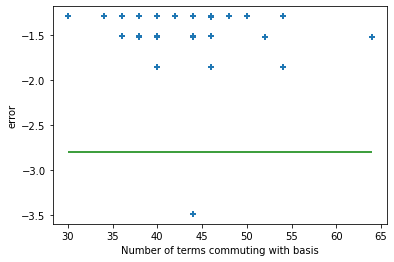

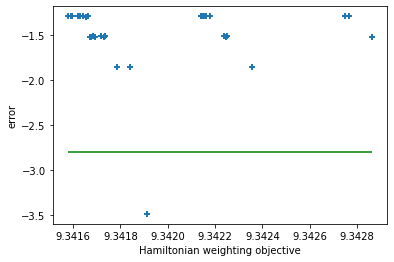

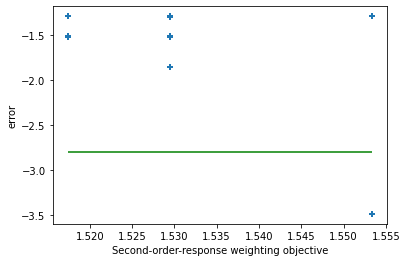

In [35]:
def plot_error(X, label):
    fig = plt.figure()
    ax = fig.add_subplot()#projection='3d')
    ax.scatter(X,np.log10(errors), marker='+')
    ax.hlines(np.log10(0.0016), min(X), max(X), color='green')
    ax.set_xlabel(label)
    ax.set_ylabel('error')
    plt.show()
    
plot_error(commute,'Number of terms commuting with basis')
plot_error(abs_sum,'Hamiltonian weighting objective')
plot_error(sor_sum,'Second-order-response weighting objective')

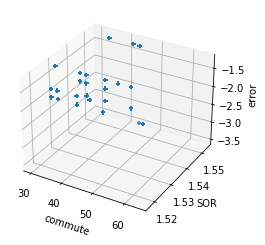

In [36]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(commute,sor_sum,np.log10(errors), marker='+')
ax.set_xlabel('commute')
ax.set_ylabel('SOR')
ax.set_zlabel('error')
plt.show()

In [31]:
print(model.symmetry_generators.to_dictionary)
model.clique_operator = PauliwordOp({'IZIZZZIZ': (-1+0j), 'IIIXIIZZ': (-5.641608257625234e-11+0j)}
)
print(model.clique_operator.to_dictionary)

{'IIIIIIIZ': (1+0j), 'IIIIIZII': (1+0j), 'IIIIZIII': (1+0j), 'IIZIIIII': (1+0j), 'IZIIZIII': (-1+0j), 'IZZIZIZI': (-1+0j), 'ZZIIIIZI': (1+0j)}
{'IZIZZZIZ': (-1+0j), 'IIIXIIZZ': (-5.641608257625234e-11+0j)}


In [32]:
basis=StabilizerOp({'IZIIIIIZ':1, 
                    'IZZIZIZI':1, 
                    'IIIIIZII':1, 
                    'IIIIZIII':1, 
                    'IIZIIIII':1, 
                    'IZIIZIII':1, 
                    'ZZIIIIZI':1})+model.clique_operator
model.update_basis(basis)
print(model.noncontextual_basis)

1+0j IZIZZZIZ +
1+0j IIIXIIZZ +
1+0j IIIIIZII +
1+0j IIIIZIII +
1+0j IIZIIIII +
1+0j IZIIIIIZ +
1+0j IZIIZIII +
1+0j IZZIZIZI +
1+0j ZZIIIIZI


In [200]:
from scipy.optimize import basinhopping

def Z_to_symplectic(Z_block):
    return np.hstack([np.zeros_like(Z_block), Z_block])

def random_Z_basis(N):
    random_Z_block = np.random.randint(0,2,(N,model.ham_tap.n_qubits))
    return Z_to_symplectic(random_Z_block)

def indices_to_symp(indices):
    assert(np.all(np.array(indices)<2**model.ham_tap.n_qubits))
    binind = [format(abs(int(i)), f'0{model.ham_tap.n_qubits}b') for i in indices]
    binind = [np.array([int(i) for i in bin]) for bin in binind]
    return Z_to_symplectic(np.vstack(binind))

def func(basis_indices):
    try:
        basis_symp = indices_to_symp(basis_indices)
        basis = StabilizerOp(basis_symp, np.ones(basis_symp.shape[0]))
        return -cheat.weighted_objective(basis, aux_operator=model.sor_tap)
    except:
        return 0
    
def func_2(basis_indices):
    try:
        basis_symp = indices_to_symp(basis_indices)
        basis = StabilizerOp(basis_symp, np.ones(basis_symp.shape[0]))
        return -np.count_nonzero(np.all(model.sor_tap.commutes_termwise(basis), axis=1))
    except:
        return 0
    
N=10
n = model.ham_tap.n_qubits
x0=2**np.arange(n-N, n)
opt_result = basinhopping(func=func, x0=x0, stepsize=2**(model.ham_tap.n_qubits//2), niter=10000)
opt_result

                        fun: (-1.106171123178879-0j)
 lowest_optimization_result:       fun: (-1.106171123178879-0j)
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
      jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 11
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ -916.45739918,  3155.31651859,   928.12084745,  3485.37152612,
        3933.32638615,  3556.89826034,  5607.64080284, 17223.67462884,
       33325.81886109, 63374.26832529])
                    message: ['requested number of basinhopping iterations completed successfully']
      min

In [202]:
basis_symp = indices_to_symp(opt_result['x'])
print(basis_symp)
basis = StabilizerOp(basis_symp, np.ones(basis_symp.shape[0]))
projected = cheat.project_onto_subspace(basis)
nrg = get_ground_state(projected.to_sparse_matrix)[0]
print(nrg-model.fci_energy)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 0]]
0.02162112233395419


In [ ]:
from quantumtools.Hamiltonian import QubitHamiltonian, HamiltonianGraph

In [ ]:
terms, coeffs = zip(*model.ham_tap.to_dictionary.items())
terms, coeffs = list(terms), list(coeffs)
graph = HamiltonianGraph(terms, coeffs)
g_dict = graph.clique_cover('C', 'largest_first')
largest_C_set = sorted(g_dict.items(), key=lambda x:-x[1].n_terms)[0][1]

In [ ]:
print(largest_C_set)

In [ ]:
basis = StabilizerOp(['IXIII', 'ZIZZZ', 'IZZII', 'IIZII', 'IIZZI', 'IIIZZ'],[1,1,1,1,1,1])
print(basis)
model.update_basis(basis=basis)

In [ ]:
for comb in combinations([0,1,2,3,4], r=2):
    comb=list(comb)
    print(comb)
    projected = model.contextual_subspace_projection(comb)
    print(get_ground_state(projected.to_sparse_matrix)[0]-true_gs)
    print()

In [13]:
f'hello {-1.000000001: .0f}'

'hello -1'

In [17]:
format(-1.00000023, '.0f')

'-1'